BCI Sample Size Determination (SSD)

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import special
import matplotlib.pyplot as plt
import json
import time

In [2]:
# sample size
# n_subjects = [4, 8, 12, 16, 24] # number of subjects
# n_trials = [20, 36, 64] # number of trials
n_subjects = [4] # number of subjects
n_trials = [20] # number of trials

M = 3 # iterations

# MCMC
n_samples = 5000
n_chains = 3
n_tune = 500

# initialize results dict
timestamp = time.strftime("%Y%m%d%H%M")
params = {'n_trials': n_trials, 'n_subjects': n_subjects, 'M': M,
           'n_samples': n_samples, 'n_chains': n_chains, 'n_tune': n_tune
          }
results = np.zeros((len(n_subjects), len(n_trials), M))

In [3]:
for s in range(len(n_subjects)):
    for t in range(len(n_trials)):
        for m in range(M):
            # print iteration info
            print("M: "+str(m)+"\t Ns: "+str(s)+"\t T: "+str(t))
            
            # draw parameters (theta hat) from sampling prior
            mu_phi = np.random.uniform(0.55, 0.95)
            mu_alpha = special.logit(mu_phi)
            sigma_alpha = np.random.uniform(0.2, 1.2)
            
            alpha = np.random.normal(mu_alpha, sigma_alpha, n_subjects[s])
            phi = special.expit(alpha)
            
            # draw dataset D^(n) from sampling distribution
            y = np.random.binomial(n_trials[t], phi) # vector of size Ns
            
            # compute delta(D^(n)) using Baye's rule (via MCMC)
            with pm.Model() as model:
                # priors for group level parameters - a single value for mean and std
                group_level_mean_logit = pm.Normal('μ_α', mu=0, sd=2**0.5)
                group_level_std_logit = pm.Uniform('σ_α', lower=0., upper=10.)
                
                group_level_mean_prob = pm.Deterministic('μ_φ', pm.math.invlogit(group_level_mean_logit))
                
                # subject level parameters - vector of size Ns
                subject_level_accuracy_logit = pm.Normal('α', mu=group_level_mean_logit, sd=group_level_std_logit, shape=n_subjects[s])
                subject_level_accuracy_prob = pm.Deterministic('φ', pm.math.invlogit(subject_level_accuracy_logit))
                
                # likelihood (sampling distributions) of observations
                y_obs = []
                for i in range(n_subjects[s]):
                    y_obs_i = pm.Binomial('y_obs_'+str(i), n=n_trials[t], p=subject_level_accuracy_prob[i], observed=y[i])
                    y_obs.append(y_obs_i)
                
                # draw posterior samples
                trace = pm.sample(n_samples, chains=n_chains, tune=n_tune, discard_tuned_samples=True)
            
            # posterior analysis
            trace_np = pd.DataFrame(trace['α']).to_numpy() # 15000 x Ns array of subject-level accuracies
            
            # take mean across all Ns subjects --> vector of 15000
            group_level_mean_logit_hat = np.mean(trace_np, axis=1)
            
            # compute 95% CI
            delta = np.percentile(group_level_mean_logit_hat, 97.5) - np.percentile(group_level_mean_logit_hat, 2.5)
            results[s][t][m] = delta


M: 0	 Ns: 0	 T: 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [α, σ_α, μ_α]
Sampling 3 chains: 100%|██████████| 16500/16500 [00:12<00:00, 1278.40draws/s]
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
There were 136 divergences after tuning. Increase `target_accept` or reparameterize.
There were 229 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


M: 1	 Ns: 0	 T: 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [α, σ_α, μ_α]
Sampling 3 chains: 100%|██████████| 16500/16500 [00:15<00:00, 1075.91draws/s]
There were 153 divergences after tuning. Increase `target_accept` or reparameterize.
There were 254 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.71245543178317, but should be close to 0.8. Try to increase the number of tuning steps.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


M: 2	 Ns: 0	 T: 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [α, σ_α, μ_α]
Sampling 3 chains: 100%|██████████| 16500/16500 [00:14<00:00, 1124.00draws/s]
There were 227 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7013202874101708, but should be close to 0.8. Try to increase the number of tuning steps.
There were 180 divergences after tuning. Increase `target_accept` or reparameterize.
There were 154 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [4]:
# Save params as json file
np.save(timestamp+'_alc_results', results)
with open(timestamp+'_alc_params.txt', 'w') as outfile:
    json.dump(params, outfile)

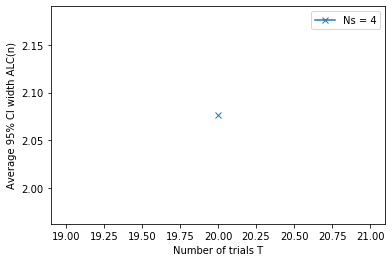

In [5]:
# Save ALC plot
plt.xlabel('Number of trials T');
plt.ylabel('Average 95% CI width ALC(n)');

for s in range(len(n_subjects)):
    ALCs = np.zeros(len(n_trials))
    for t in range(len(n_trials)):
        ALCs[t] = np.mean(results[s][t])
    plt.plot(n_trials, ALCs, marker='x', label='Ns = '+str(n_subjects[s]))

plt.legend();

plt.savefig(timestamp+'_alc_plot');

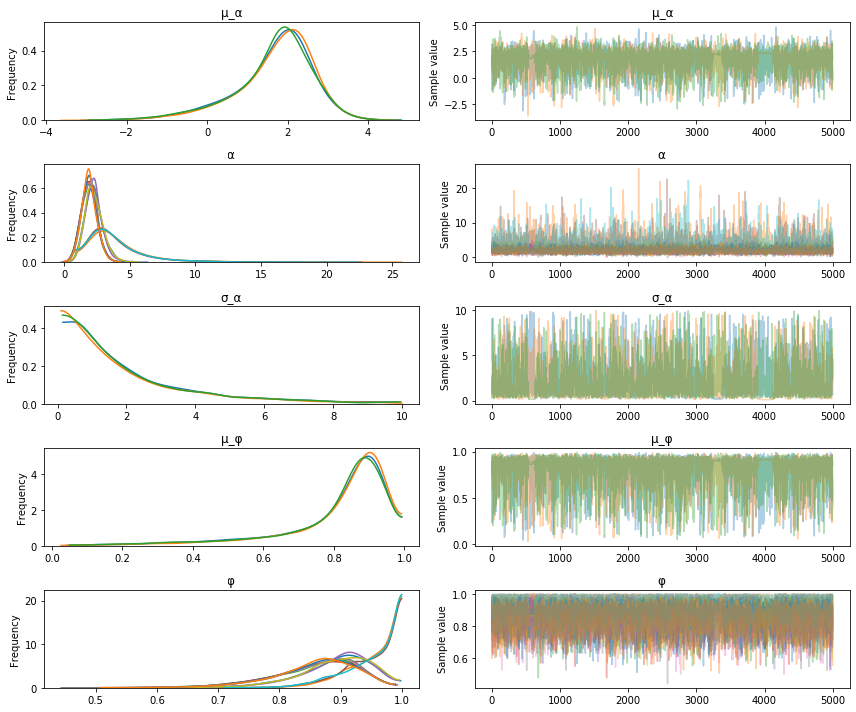

In [6]:
# Save trace plot
pm.traceplot(trace);
fig = plt.gcf();
fig.savefig(timestamp+'_alc_trace.png')